# Bitcoin Price Forecasting 

### Bitcoin's meteoric rise in the world of finance has captured global attention, making accurate price prediction more critical than ever. Enter ARIMA, a proven time series forecasting method. In this project, we explore the power of ARIMA in predicting Bitcoin prices. Dive into the world of cryptocurrency and data science, and equip yourself with insights to navigate Bitcoin's dynamic market with confidence.

In [1]:
# we'll be using the yfinance package to download the data for bitcoin

!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
#download the bitcoin data
df = yf.download('BTC-USD')

[*********************100%%**********************]  1 of 1 completed


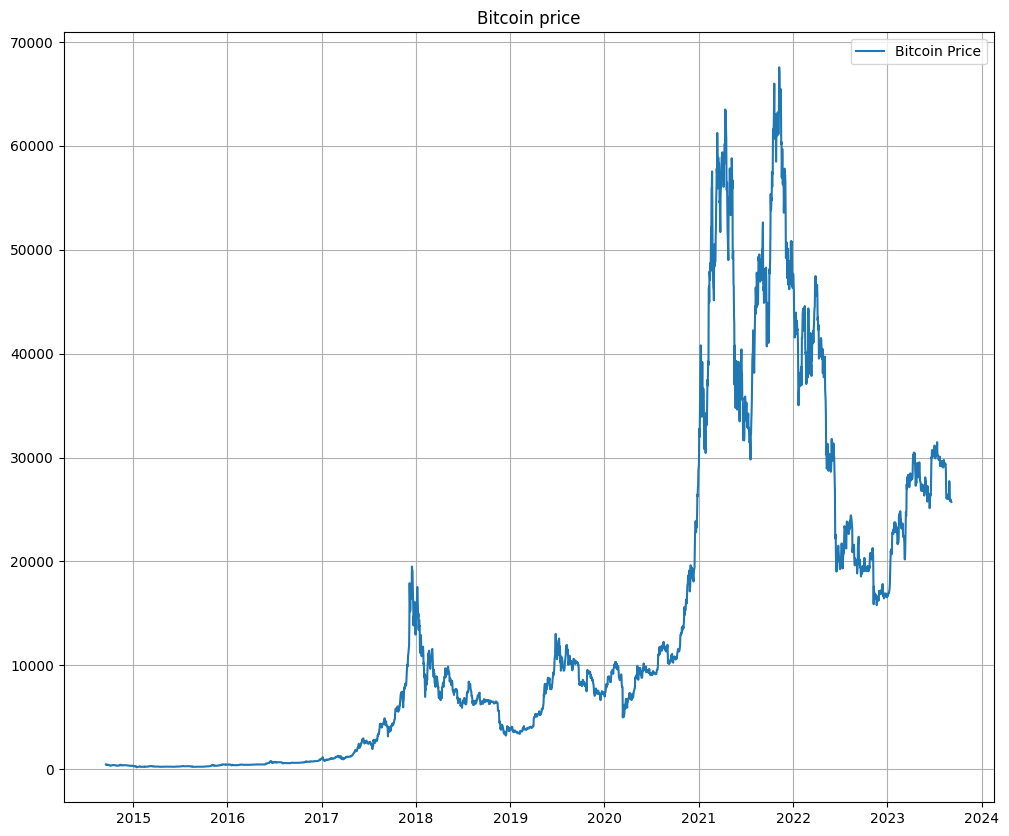

In [4]:
#plot the bitcoin price 
fig, ax = plt.subplots(figsize=(12,10))
plt.plot(df.index, df['Adj Close'], label = 'Bitcoin Price')
plt.legend()
plt.title('Bitcoin price')
plt.grid(True)
plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3277 entries, 2014-09-17 to 2023-09-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3277 non-null   float64
 1   High       3277 non-null   float64
 2   Low        3277 non-null   float64
 3   Close      3277 non-null   float64
 4   Adj Close  3277 non-null   float64
 5   Volume     3277 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 179.2 KB


## Time Series Decomposition

   - Time series decomposition is a fundamental technique in time series analysis that helps data scientists, analysts, and forecasters understand and model temporal data more effectively. It is particularly valuable when working with data that exhibits seasonality and trend components, common in various domains such as finance, economics, weather forecasting, and more.
    
    
### Key Components of Time Series Decomposition:

   1.  Trend Component: The trend component represents the long-term, underlying pattern in the time series data. It captures the overall direction in which the data is moving. Identifying trends can be crucial for making informed decisions and predictions.

   2. Seasonal Component: The seasonal component represents repetitive, periodic patterns within the data, such as daily, weekly, or yearly patterns. Seasonal decomposition helps reveal the impact of seasonality on the time series, allowing for better forecasting and anomaly detection.

   3. Residual Component: The residual component, often referred to as the noise or error component, accounts for random variations and irregularities that cannot be attributed to trends or seasonality. Analyzing residuals helps identify unusual events or anomalies in the data.

Text(0, 0.5, 'Residual')

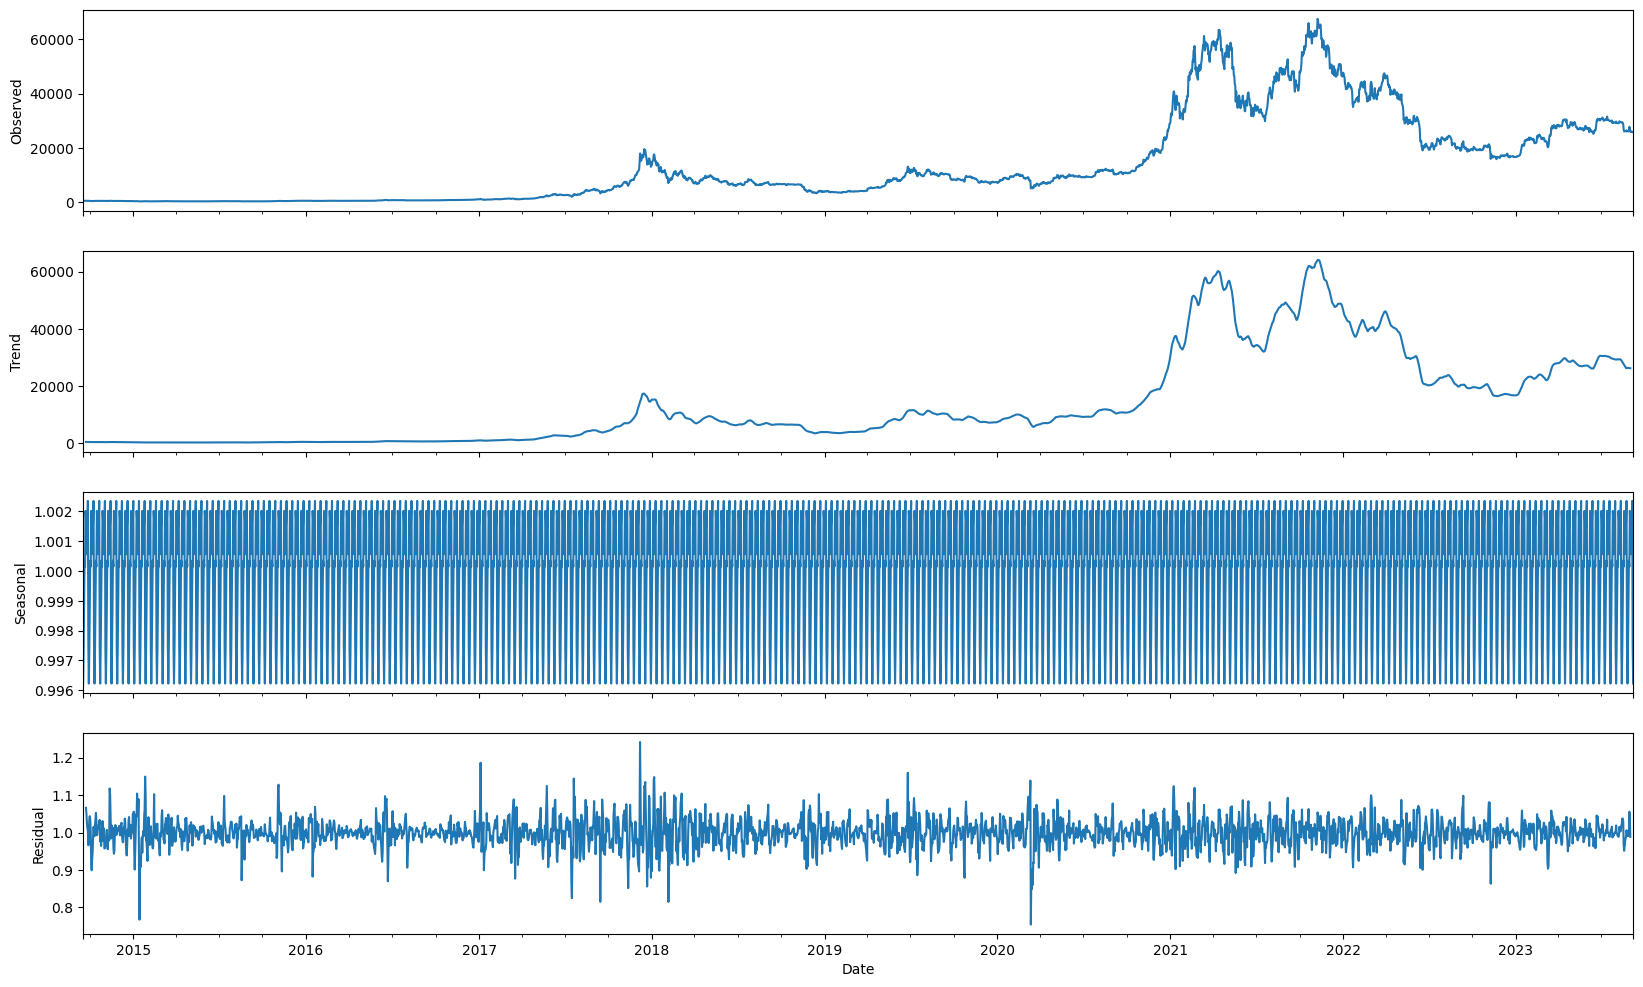

In [6]:
import statsmodels.api as sm

result = sm.tsa.seasonal_decompose(df['Adj Close'], period=12, model='multiplicative')

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(20, 12), sharex=True)

# Plot each component separately
result.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')

Observed:

-clearly the time series has a varying trend 

# >>>ARIMA(p,d,q)

   - ARIMA, which stands for AutoRegressive Integrated Moving Average, is a powerful and widely used technique in time series forecasting. Whether you're predicting stock prices, weather patterns, or sales data, understanding ARIMA can be the key to unlocking accurate and insightful predictions from your time-dependent data.
   
   
 ### Key Concepts of ARIMA:

- AutoRegressive Component (p): The "p" in ARIMA represents the autoregressive order, which denotes the number of past observations used to predict the current value. This component captures the relationship between the current value and its own lagged values.

- Integrated Component (d): The "d" in ARIMA signifies the integrated order, and it involves differencing the time series data to achieve stationarity. A stationary series has stable statistical properties, such as a constant mean and variance. "d" indicates the number of differences needed to make the data stationary.

- Moving Average Component (q): The "q" in ARIMA stands for the moving average order, which specifies the number of past forecast errors used to predict the current value. This component helps account for short-term fluctuations in the time series.

lets now move on and determine p, d, & q

### **CHECK FOR STATIONARITY**
  -  stationarity refers to a key assumption that the time series data should have certain statistical properties that remain consistent over time. A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation, do not change with time. Stationarity is an important concept because many time series forecasting methods, including ARIMA, assume or work best with stationary data
  
  
  

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
#create a function that plots and check for stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

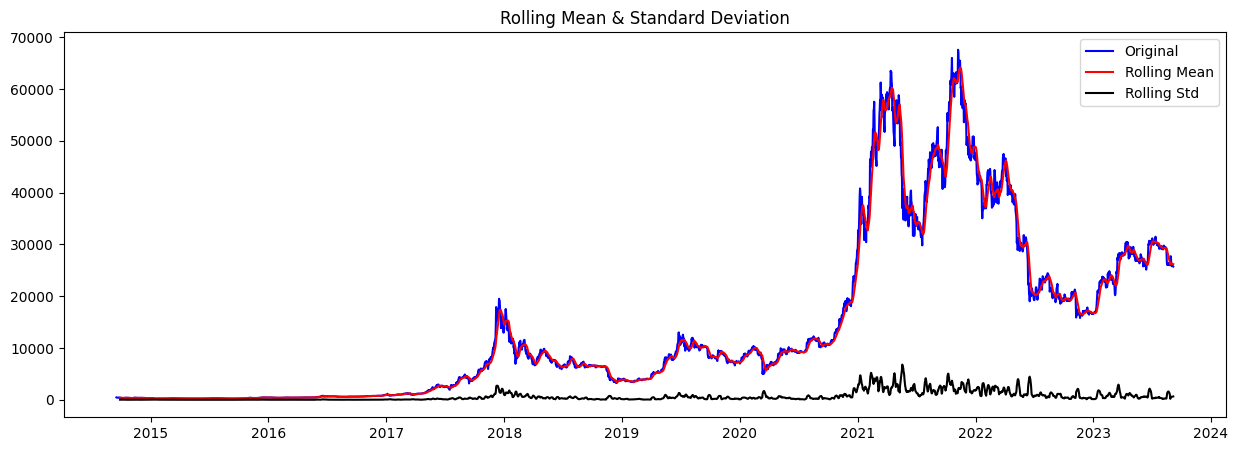

Results of Dickey-Fuller Test:
Test Statistic                   -1.636590
p-value                           0.464043
#Lags Used                       29.000000
Number of Observations Used    3247.000000
Critical Value (1%)              -3.432366
Critical Value (5%)              -2.862431
Critical Value (10%)             -2.567244
dtype: float64


In [9]:
test_stationarity(df['Adj Close'])

Observation:
- The rolling mean exhibits significant variation, signaling that the time series lacks stationarity.
- Our analysis of the p-value at a 5% significance level suggests that we do not have sufficient evidence to reject the null hypothesis. This indicates the potential presence of a unit root in the time series, which typically implies non-stationarity.

## Differencing

   - Differencing is a fundamental technique in time series analysis that plays a crucial role in preparing time-dependent data for modeling and analysis. It involves subtracting the previous value from the current value in a time series, and it can help transform non-stationary data into a more stationary form. Whether you're working with financial data, sensor measurements, or any other sequential data, understanding differencing is essential for uncovering meaningful patterns and making accurate forecasts.
    

In [10]:
df_diff1 = df['Adj Close'].diff().dropna()

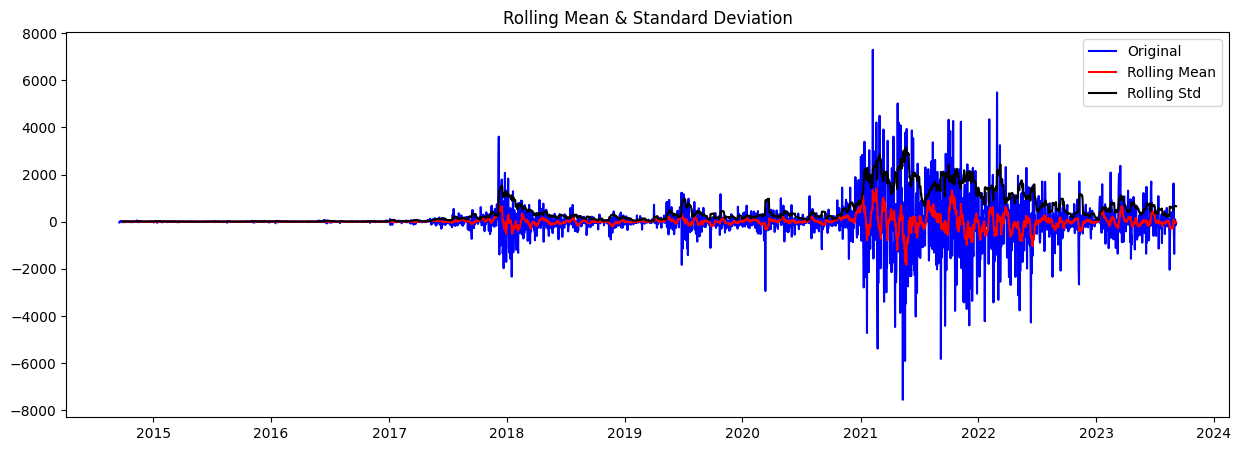

Results of Dickey-Fuller Test:
Test Statistic                -9.562031e+00
p-value                        2.411556e-16
#Lags Used                     2.800000e+01
Number of Observations Used    3.247000e+03
Critical Value (1%)           -3.432366e+00
Critical Value (5%)           -2.862431e+00
Critical Value (10%)          -2.567244e+00
dtype: float64


In [11]:
test_stationarity(df_diff1)

Observation:

 - Considering the p-values, it appears that first-order differencing is sufficient. Therefore, let's proceed by assuming d equals 1.

# Train - Test Split


In [12]:
#We will perform a dataset split using the date as the reference point, with the split occurring at January 1, 2023.
DateRange_train = df.loc[df.index < '2023-01-01'].index
DateRange_test = df.loc[df.index >= '2023-01-01'].index
train = pd.DataFrame(df.loc[df.index < '2023-01-01', 'Adj Close'])
test = pd.DataFrame(df.loc[df.index >= '2023-01-01', 'Adj Close'])

In [13]:
train['Adj Close Diff'] = train['Adj Close'].diff().dropna()

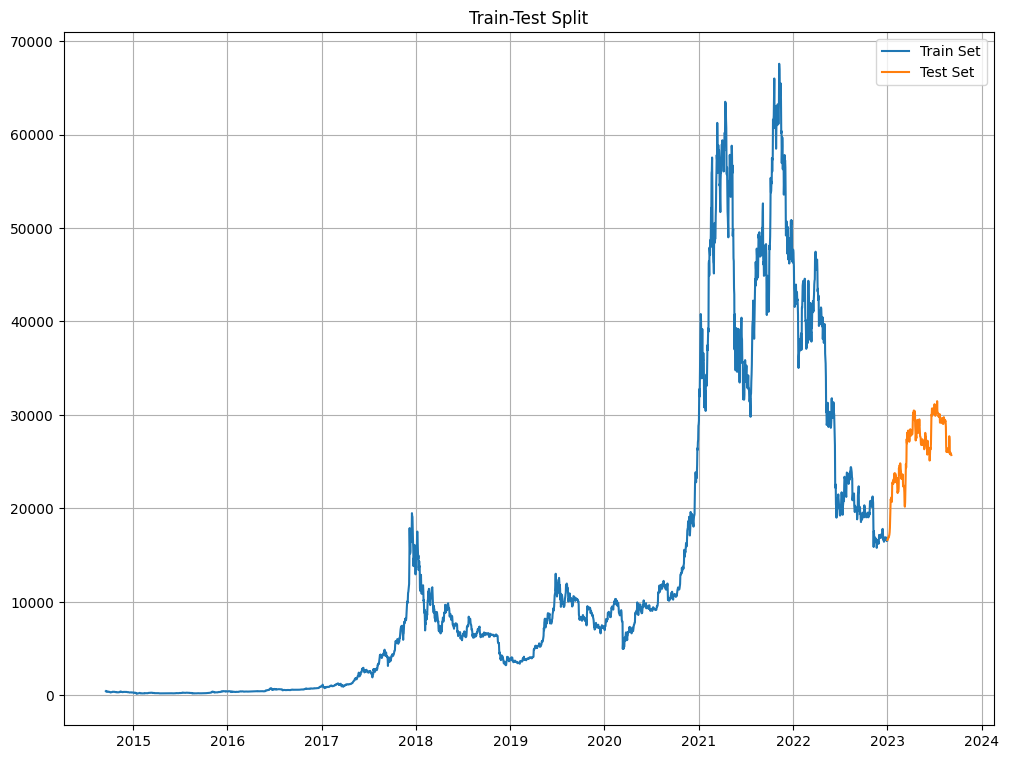

In [14]:
plt.figure(figsize = (12,9))
plt.grid(True)
plt.plot(df.loc[df.index < '2023-01-01'].index, 
         df.loc[df.index < '2023-01-01','Adj Close'], label='Train Set')
plt.plot(df.loc[df.index >= '2023-01-01'].index, 
         df.loc[df.index >= '2023-01-01','Adj Close'], label='Test Set')
#plt.axvline(x= '2023-01-01', color='red', linestyle='--', label='Vertical Line at x=3')
plt.legend()
plt.title('Train-Test Split')
plt.show()

# ARIMA MODELLING

In [15]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.api as smt

# define a function to plot ACF and PACF to determine p and q
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[0]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

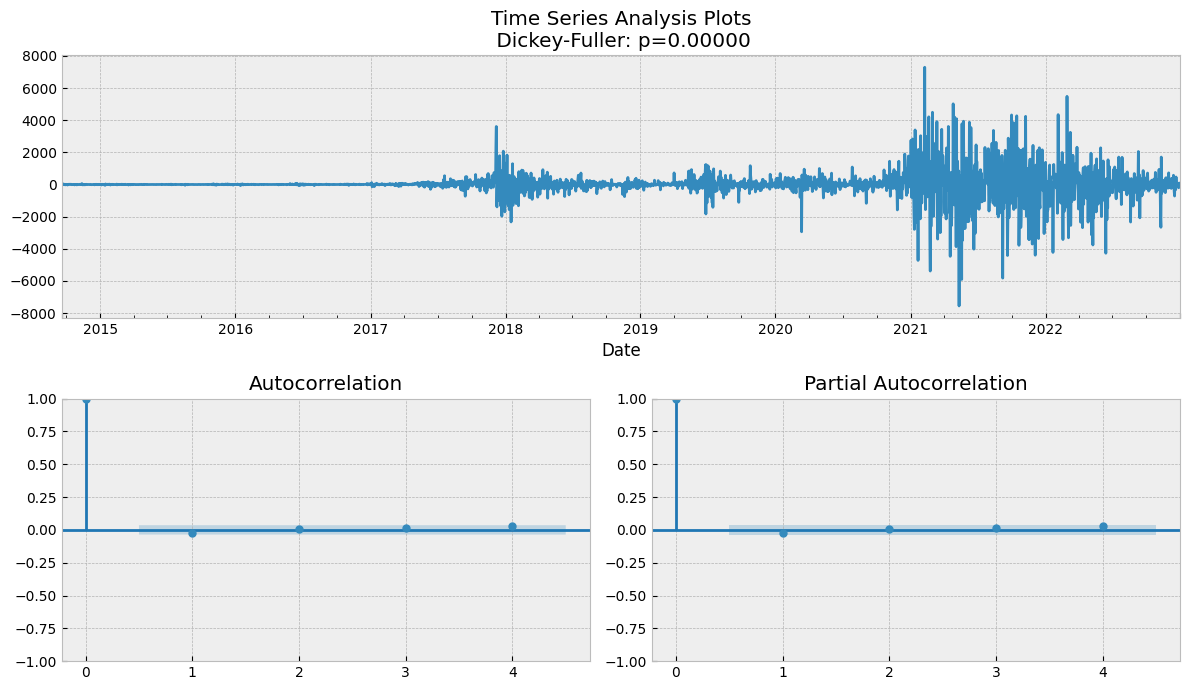

In [16]:
tsplot(train['Adj Close Diff'].dropna(),lags=4)

Observation:
   - ACF and PACF plots lack significant spikes crossing the significance bands, it suggests minimal autocorrelation or partial autocorrelation patterns, common in time series data without strong seasonality or autocorrelation.  with this lets assume p and q as 0

In [17]:
model = ARIMA(train['Adj Close Diff'],order = (0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Adj Close Diff   No. Observations:                 3028
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -25598.377
Date:                Wed, 06 Sep 2023   AIC                          51198.754
Time:                        09:21:07   BIC                          51204.770
Sample:                    09-17-2014   HQIC                         51200.917
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.296e+06   1.21e+04    107.281      0.000    1.27e+06    1.32e+06
Ljung-Box (L1) (Q):                 802.34   Jarque-Bera (JB):             22035.80
Prob(Q):                              0.00   Pr

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### In-sample Rolling Forecasting

-in in-sample rolling forecast, also known as a rolling forecast origin or recursive forecast, involves making forecasts on a time series using an ARIMA model where the model is updated and refitted at each step, using actual observations up to that point.

In [18]:
# in-sample rolling forecast
# split the training set removing the last 2 months 
train_in_sample , test_in_sample = train.loc[train.index < '2022-10-01','Adj Close'], train.loc[train.index >= '2022-10-01','Adj Close']

size = len(test_in_sample)

history = [x for x in train_in_sample] ## list
predictions = []

for t in range(size):
    
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test_in_sample[t]
    history.append(obs)
    
#     print('predicted = %f, expected = %f' % (yhat, obs))

In [19]:
#recreate the dataset for forecasted values
forecasted_values =  pd.DataFrame({
    
    'Date' : test_in_sample.index,
    'Actual Values' : test_in_sample.values,
    'Forecast Values' : predictions
    
})
forecasted_values.head(10)

,Date,Actual Values,Forecast Values
0,2022-10-01,19312.095703,19431.789062
1,2022-10-02,19044.107422,19312.095703
2,2022-10-03,19623.580078,19044.107422
3,2022-10-04,20336.843750,19623.580078
4,2022-10-05,20160.716797,20336.843750
5,2022-10-06,19955.443359,20160.716797
6,2022-10-07,19546.849609,19955.443359
7,2022-10-08,19416.568359,19546.849609
8,2022-10-09,19446.425781,19416.568359
9,2022-10-10,19141.484375,19446.425781


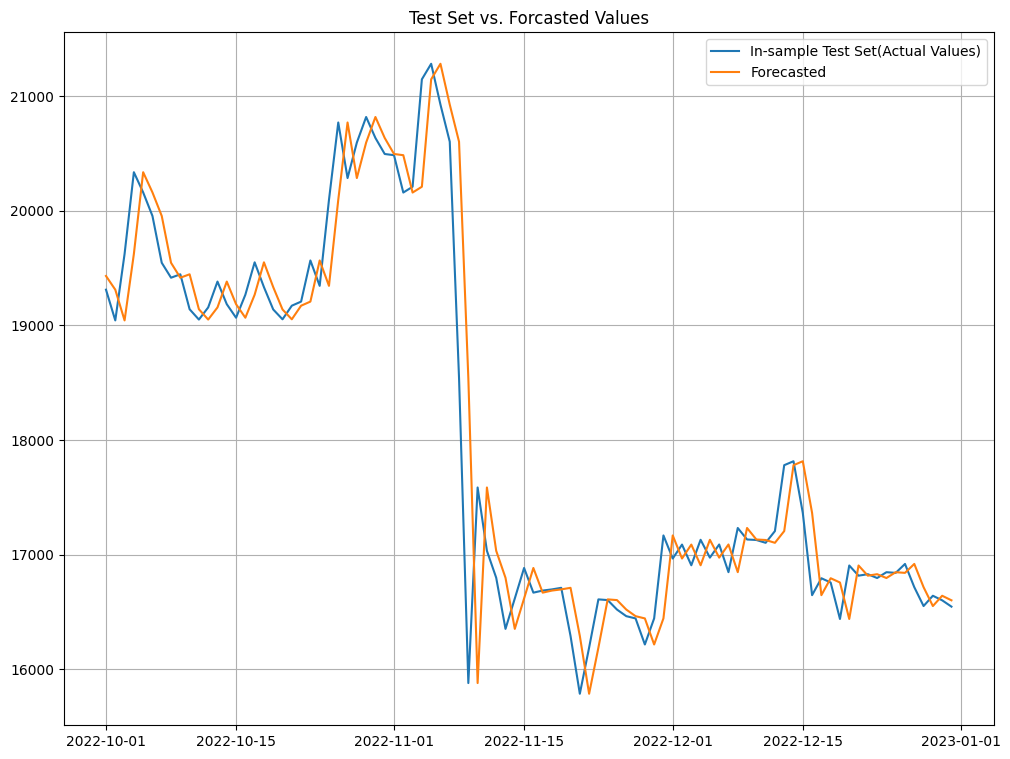

In [20]:
#plot the forecasted values vs the actual values for the in sample test set
fig, ax = plt.subplots(figsize = (12,9))
plt.plot(test_in_sample.index, test_in_sample.values, label = 'In-sample Test Set(Actual Values)')
plt.plot(forecasted_values.Date, forecasted_values['Forecast Values'], label='Forecasted')
plt.title('Test Set vs. Forcasted Values')

plt.legend()
plt.grid(True)
plt.show()

Observation:
 - It appears that the forecasted values consistently lead the actual values in the in-sample rolling forecast. Despite this lead, the forecasted values generally exhibit a reasonably close alignment with the actual values. This suggests that the ARIMA model has a proactive nature in capturing underlying trends and patterns, providing early indications of future data points.

### Out-of-Samle Forecasting
 - also known as a forward forecast or expanding window forecast, involves making forecasts on a time series using an ARIMA model where the model is initially trained on a fixed historical period and then used to make predictions for future time points that were not part of the training data.

In [21]:
#reset the list
train_list = [] 
test_list = []

In [22]:
#forecasting with the test set

size = len(test)

train_list = [x for x in train['Adj Close']] 
test_list = [x for x in test['Adj Close']]
forecast = []

for t in range(size):
    
    model = ARIMA(train_list, order=(0,1,0))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    forecast.append(float(yhat))
    
    obs = test_list[t]
    train_list.append(obs)

In [23]:
#forecasted values out of 
forecasted_values =  pd.DataFrame({
    'Date' : test.index,
    'Actual Values' : test['Adj Close'],
    'Pred' : forecast
})
forecasted_values.head()

,Date,Actual Values,Pred
Date,,,
2023-01-01,2023-01-01,16625.080078,16547.496094
2023-01-02,2023-01-02,16688.470703,16625.080078
2023-01-03,2023-01-03,16679.857422,16688.470703
2023-01-04,2023-01-04,16863.238281,16679.857422
2023-01-05,2023-01-05,16836.736328,16863.238281


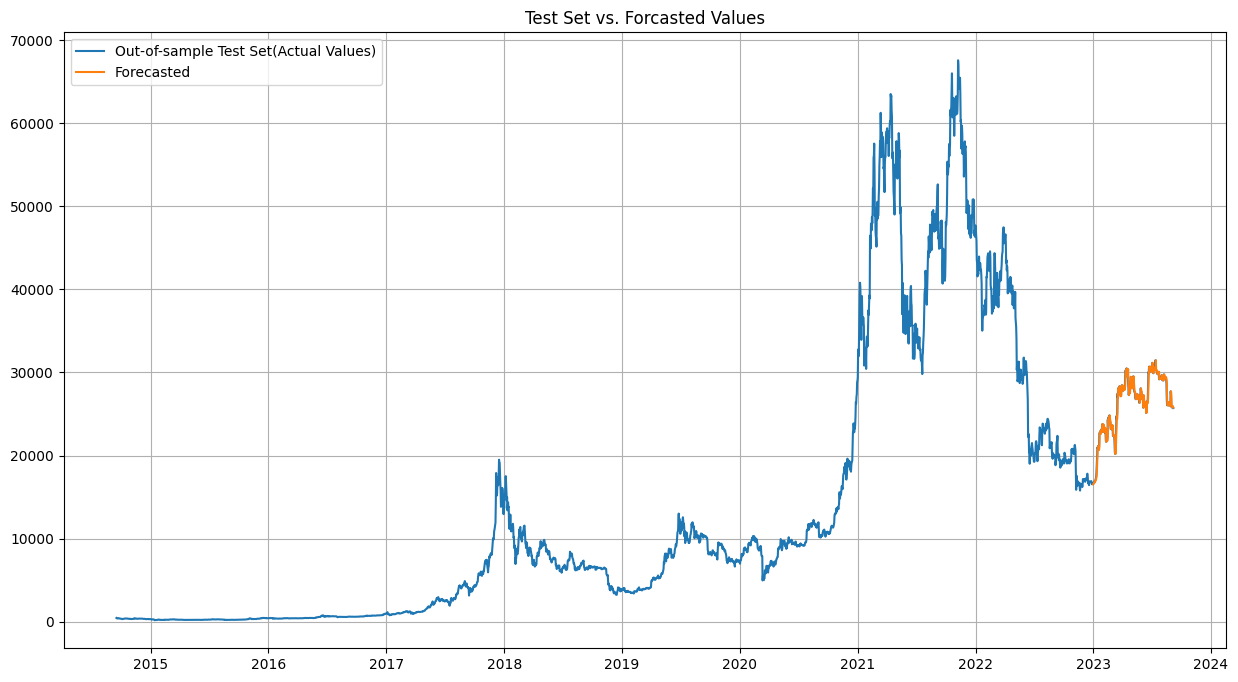

In [24]:
#plot the forecasted values vs the actual values for the out-of-sample test set
fig, ax = plt.subplots(figsize = (15,8))
plt.plot(df.index, df['Adj Close'], label = 'Out-of-sample Test Set(Actual Values)')
plt.plot(forecasted_values['Date'], forecasted_values['Pred'], label='Forecasted')
plt.title('Test Set vs. Forcasted Values')

plt.legend()
plt.grid(True)
plt.show()

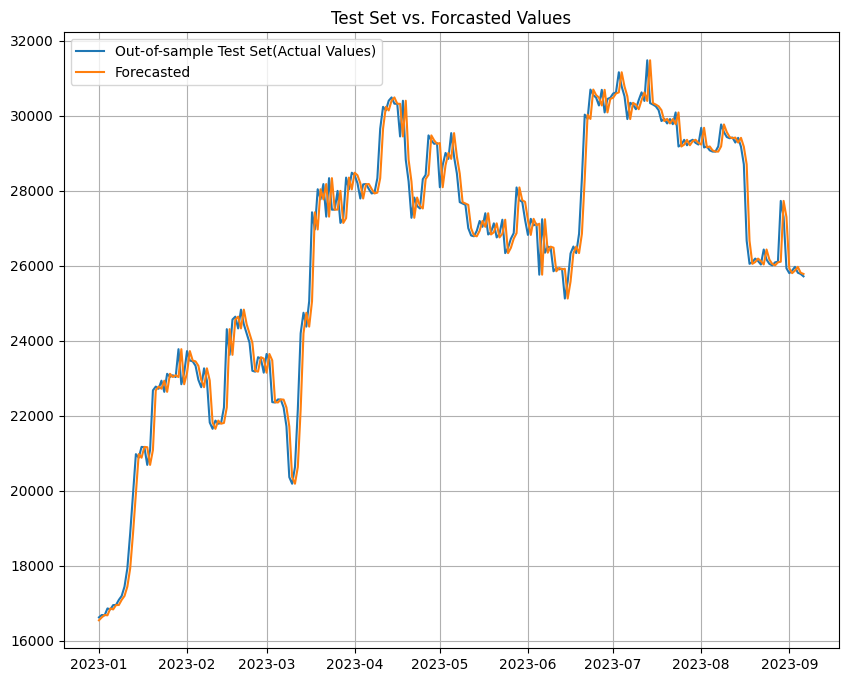

In [25]:
#plot the forecasted values vs the actual values for the out-of-sample test set
fig, ax = plt.subplots(figsize = (10,8))
plt.plot(forecasted_values['Date'], forecasted_values['Actual Values'], label = 'Out-of-sample Test Set(Actual Values)')
plt.plot(forecasted_values['Date'], forecasted_values['Pred'], label='Forecasted')
plt.title('Test Set vs. Forcasted Values')

plt.legend()
plt.grid(True)
plt.show()

Observation:
 - During the out-of-sample rolling forecast, it's evident that the predicted values consistently lead the actual values, albeit by a slight margin. This slight lead indicates that the ARIMA model exhibits a proactive forecasting nature, providing forecasts that anticipate future data points with precision.

In [26]:
forecasted_values.head(10)

,Date,Actual Values,Pred
Date,,,
2023-01-01,2023-01-01,16625.080078,16547.496094
2023-01-02,2023-01-02,16688.470703,16625.080078
2023-01-03,2023-01-03,16679.857422,16688.470703
2023-01-04,2023-01-04,16863.238281,16679.857422
2023-01-05,2023-01-05,16836.736328,16863.238281
2023-01-06,2023-01-06,16951.968750,16836.736328
2023-01-07,2023-01-07,16955.078125,16951.968750
2023-01-08,2023-01-08,17091.144531,16955.078125
2023-01-09,2023-01-09,17196.554688,17091.144531


In [27]:
forecasted_values.tail(10)

,Date,Actual Values,Pred
Date,,,
2023-08-28,2023-08-28,26106.150391,26089.693359
2023-08-29,2023-08-29,27727.392578,26106.150391
2023-08-30,2023-08-30,27297.265625,27727.392578
2023-08-31,2023-08-31,25931.472656,27297.265625
2023-09-01,2023-09-01,25800.724609,25931.472656
2023-09-02,2023-09-02,25868.798828,25800.724609
2023-09-03,2023-09-03,25969.566406,25868.798828
2023-09-04,2023-09-04,25812.416016,25969.566406
2023-09-05,2023-09-05,25779.982422,25812.416016


In [28]:
ape = np.abs((forecasted_values['Pred'] - forecasted_values['Actual Values']) / forecasted_values['Actual Values'])
mape = np.mean(ape) * 100

In [29]:
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 1.55%


Observation:
 - The calculated Mean Absolute Percentage Error (MAPE) of 1.55% reflects a high level of accuracy in our forecasting model. This low MAPE indicates that, on average, our model's predictions closely align with the actual values. Such accuracy is promising and suggests that the model performs well in capturing underlying trends and patterns in the data.